In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load the data

In [2]:
# Load the parquet dataframe in pandas
pd_df = pd.read_parquet("../data/clean_data/df_trans_sent_comments.parquet")

# Display info of dataframe
pd_df.info()

# Drop Nan val# ues
pd_df.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184673 entries, 0 to 184672
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   comment_id         184673 non-null  object             
 1   author             184673 non-null  object             
 2   author_channel_id  184673 non-null  object             
 3   text               184673 non-null  object             
 4   like_count         184673 non-null  float64            
 5   published_at       184673 non-null  datetime64[ns, UTC]
 6   updated_at         184673 non-null  datetime64[ns, UTC]
 7   totalReplyCount    184673 non-null  float64            
 8   video_id           184673 non-null  object             
 9   translation        184670 non-null  object             
 10  clean_text         184670 non-null  object             
 11  sentiment          184670 non-null  float64            
dtypes: datetime64[ns, UTC](2), flo

# Sentiment Analysis using RoBERTa
* NLP Transformer-based Models used for Sentiment Analysis

* RoBERTa: Robustly Optimized BERT Approach
* BERT: Bidirectional Encoder Representations from Transformers

* Optimised using datasets from Huggingface: structure optimised for NLP

In [ ]:
from datasets import Dataset
from transformers import pipeline

# Load the sentiment analysis model with GPU support if available
sentiment_model = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=5, device=0)

# Define a function to process a batch of texts and return the raw output without truncating the tokens
def apply_sentiment(batch):
    # Ensure 'clean_text' is a list of texts in the batch
    texts = batch['clean_text_truncated']
    
    # Process each text without truncating tokens
    sentiments = [sentiment_model(text) for text in texts]  # No token truncation, raw model output
    
    # Add the raw sentiment analysis result back to the batch
    batch['emotions'] = sentiments
    
    return batch

# Safe copy of the dataframe
df_test = pd_df.copy()

# Truncate the text up to 512 tokens
def truncate_text(text):
    return text[:512]
df_test["clean_text_truncated"] = df_test["clean_text"].apply(truncate_text)

# Convert the PySpark DataFrame to Pandas and then to a Hugging Face Dataset
dataset = Dataset.from_pandas(df_test)

# Apply the sentiment analysis model in batches
dataset = dataset.map(apply_sentiment, batched=True, batch_size=64)

# Convert the dataset back to a pandas DataFrame if needed
df_result = dataset.to_pandas()

/home/ivanseldasp/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/184670 [00:00<?, ? examples/s]

Convert RoBERTa output into a dictionary 'label:score'

In [ ]:
# Create the function
def get_label_dict(emotion_list):
    emotion_dict = {}
    for label in emotion_list[0]:
        emotion_dict[label['label']] = label['score']
    return emotion_dict

# Apply the function to the column
df_result["emotions"] = df_result["emotions"].apply(get_label_dict)

In [79]:
# Save dataframe locally
df_result.to_parquet("../data/clean_data/df_comments_emotions_nlp.parquet")

# PySpark for Sentiment Analysis: initial GPU configuration

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import broadcast
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.storagelevel import StorageLevel

In [3]:
# Create a Spark sesion
spark = SparkSession.builder.getOrCreate()

your 131072x1 screen size is bogus. expect trouble
24/11/01 15:41:43 WARN Utils: Your hostname, DESKTOP-AEUBGUH resolves to a loopback address: 127.0.1.1; using 172.17.252.233 instead (on interface eth0)
24/11/01 15:41:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/01 15:41:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Amply the memory up to 8GB
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", 8000 * 1024 * 1024)

In [5]:
# Get the threshold value and remove the non-numeric part (the 'b' character for bytes)
threshold_value = spark.conf.get("spark.sql.autoBroadcastJoinThreshold").rstrip('b')

# Convert the cleaned value to an integer and calculate the size in MB
size = int(threshold_value) / (1024 * 1024)

# Print the result
print(f"Default size of broadcast table is {size} MB.")

Default size of broadcast table is 8000.0 MB.


# Load PySpark Dataframe

In [6]:
# Load dataframe
df_result = pd.read_parquet("../data/clean_data/df_comments_emotions_nlp.parquet")

# Create spark dataframe from pandas dataframe
df_spark = spark.createDataFrame(df_result)
df_spark.show(5)

24/11/01 15:42:09 WARN TaskSetManager: Stage 0 contains a task of very large size (9365 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+------------------+--------------------+--------------------+----------+-------------------+-------------------+---------------+-----------+--------------------+--------------------+---------+--------------------+-----------------+--------------------+
|          comment_id|            author|   author_channel_id|                text|like_count|       published_at|         updated_at|totalReplyCount|   video_id|         translation|          clean_text|sentiment|clean_text_truncated|__index_level_0__|            emotions|
+--------------------+------------------+--------------------+--------------------+----------+-------------------+-------------------+---------------+-----------+--------------------+--------------------+---------+--------------------+-----------------+--------------------+
|UgxqJ2eO2p7w2NEvB...|@emmanuelamama1991|UCdUooL3DTt3Wj0M3...|great video,helpful.|       1.0|2024-08-17 15:07:48|2024-08-17 15:07:48|            1.0|qtlUwwtvuEg|great video,h

In [7]:
df_spark.dtypes

[('comment_id', 'string'),
 ('author', 'string'),
 ('author_channel_id', 'string'),
 ('text', 'string'),
 ('like_count', 'double'),
 ('published_at', 'timestamp'),
 ('updated_at', 'timestamp'),
 ('totalReplyCount', 'double'),
 ('video_id', 'string'),
 ('translation', 'string'),
 ('clean_text', 'string'),
 ('sentiment', 'double'),
 ('clean_text_truncated', 'string'),
 ('__index_level_0__', 'bigint'),
 ('emotions', 'map<string,double>')]

# PySpark: UDF function

In [8]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# Diccionario que mapea emociones a un valor entre -1 y 1
emotion_sentiment_map = {
    'admiration': 1,
    'approval': 0.8,
    'gratitude': 1,
    'neutral': 0,
    'optimism': 0.7,
    'disapproval': -0.7,
    'realization': 0.5,
    'curiosity': 0.4,
    'excitement': 0.9,
    'annoyance': -0.6,
    'joy': 1,
    'disappointment': -0.6,
    'confusion': -0.3,
    'surprise': 0.2,
    'love': 1,
    'pride': 0.9,
    'sadness': -0.8,
    'caring': 0.8,
    'amusement': 0.7,
    'anger': -0.9,
    'desire': 0.5,
    'disgust': -1,
    'relief': 0.6,
    'fear': -0.9,
    'remorse': -0.7,
    'grief': -0.9,
    'embarrassment': -0.4,
    'nervousness': -0.5
}

# Check whether the input is empty
def calculate_sentiment(emotions):
    if len(emotions) == 0:
        return 0.0

    # return (float(len(emotions)))

    # Create an initial list with all the emotion's scores
    initial_score_list = []
    for label in emotions:
        if emotions[label] is not None:
            score = emotions[label]
            initial_score_list.append(score)

    # Sum the total initial score
    initial_score_total = sum(initial_score_list)

    # Multiply each percentage of the emotion per the value from the emotion_dictionary_values
    emotion_score_list = []
    for label in emotions:
        if emotions[label] is not None:
            score = emotions[label] / initial_score_total
            final_score = emotion_sentiment_map[label] * score
            emotion_score_list.append(final_score)

    # Sum the total value pondered
    return sum(emotion_score_list)

sentiment_model = udf(calculate_sentiment, FloatType())

df_with_sentiment = df_spark.withColumn("emotion_score", sentiment_model(df_spark["emotions"]))

In [9]:
df_with_sentiment.select("video_id", "emotion_score").show(10)

24/11/01 15:42:12 WARN TaskSetManager: Stage 1 contains a task of very large size (9365 KiB). The maximum recommended task size is 1000 KiB.


+-----------+-------------+
|   video_id|emotion_score|
+-----------+-------------+
|qtlUwwtvuEg|    0.9666206|
|qtlUwwtvuEg|   0.98379844|
|qtlUwwtvuEg|    0.9885464|
|qtlUwwtvuEg|    0.9950938|
|qtlUwwtvuEg|   0.98620284|
|qtlUwwtvuEg|  0.014072355|
|qtlUwwtvuEg|   0.96756154|
|qtlUwwtvuEg|    0.9724453|
|qtlUwwtvuEg|   0.97572625|
|qtlUwwtvuEg|    0.9866275|
+-----------+-------------+
only showing top 10 rows



# PySpark: SQL query

In [10]:
# Get the desired columns
df_final = df_with_sentiment.select("video_id", "like_count", "emotion_score")

# Register the DataFrame as a temporary SQL view
df_final.createOrReplaceTempView("sentiment_data")

## Weighted Sentiment Score

$$
\text{sentiment\_media\_video} = \frac{\sum_{i=1}^{n} \left(\text{sentiment\_comment}_i \times (\text{n\_likes\_per\_comment}_i + 1)\right)}{\text{n\_comments} + \text{n\_likes\_total}}
$$

In [11]:
# Execute SQL query to apply the same logic as the PySpark code
df_weighted_sentiment_sum = spark.sql("""
    WITH subquery AS (
    SELECT
        video_id,
        SUM(like_count + 1) AS total_likes,
        SUM((like_count + 1) * emotion_score) AS score_x_emotion
    FROM
        sentiment_data
    GROUP BY
        video_id
    )
    SELECT
        s.video_id,
        (s.score_x_emotion / s.total_likes) AS final_emotion_score
    FROM subquery s
""")

In [12]:
df_weighted_sentiment_sum.show(10)

24/11/01 15:42:13 WARN TaskSetManager: Stage 2 contains a task of very large size (9365 KiB). The maximum recommended task size is 1000 KiB.


+-----------+-------------------+
|   video_id|final_emotion_score|
+-----------+-------------------+
|96-u9s6D16k| 0.5903172061849506|
|s1qZbsytk08|0.07676181044234594|
|erFxR8DNu_Q| 0.9868854880332947|
|M9a0XrkdBf4| 0.7205628536175936|
|wQ8BIBpya2k|0.27070582827040085|
|LeJkB_Moejs| 0.5637741315877065|
|vq2nnJ4g6N0| 0.2807055507151728|
|fxYtAtIq8rY| 0.3508107556651036|
|957fQCm5aDo|0.34214369648173687|
|BJ6kyj-st9k|0.29239623910182394|
+-----------+-------------------+
only showing top 10 rows



In [13]:
# Save data as parts 
# df_weighted_sentiment_sum.write.csv("../data/clean/df_videoid_emotionscore.csv")

# Sentiment Analysis

Create a column per emotion with its score

In [14]:
# This will convert each dictionary into a row with columns for each emotion
df_emotions = df_result['emotions'].apply(pd.Series)

# Now, merge the new columns back into the original DataFrame if needed
df_result = pd.concat([df_result, df_emotions], axis=1)

In [15]:
df_result.iloc[:10].to_csv('../data/df_temp.csv')

In [16]:
selected_columns = ['admiration', 'amusement', 'anger',
       'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire',
       'disappointment', 'disapproval', 'disgust', 'embarrassment',
       'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
       'nervousness', 'neutral', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise']

In [17]:
emotion_group = df_result.groupby("video_id")[selected_columns].sum()

In [18]:
all_emotions = emotion_group.sum()

# 1. Emotion Distribution Analysis

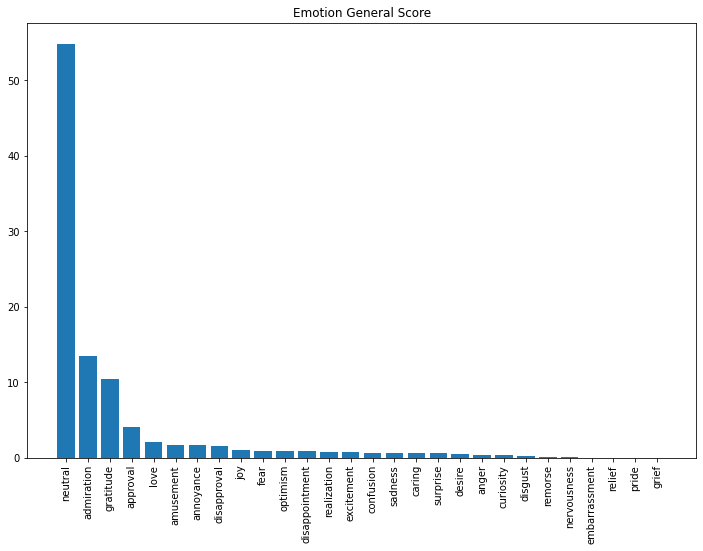

In [19]:
plt.figure(figsize=(12,8))
all_emotions.sort_values(ascending=False, inplace=True)
plt.bar(x=all_emotions.index, height=all_emotions/sum(all_emotions) * 100)
plt.xticks(rotation=90)
plt.title("Emotion General Score")
plt.show();

# 2. Multi-class Analysis

In [20]:
df_multiclass = df_with_sentiment.select("video_id", "like_count", "emotion_score")

In [21]:
df_comments_score = df_multiclass.toPandas()

24/11/01 15:42:53 WARN TaskSetManager: Stage 5 contains a task of very large size (9365 KiB). The maximum recommended task size is 1000 KiB.


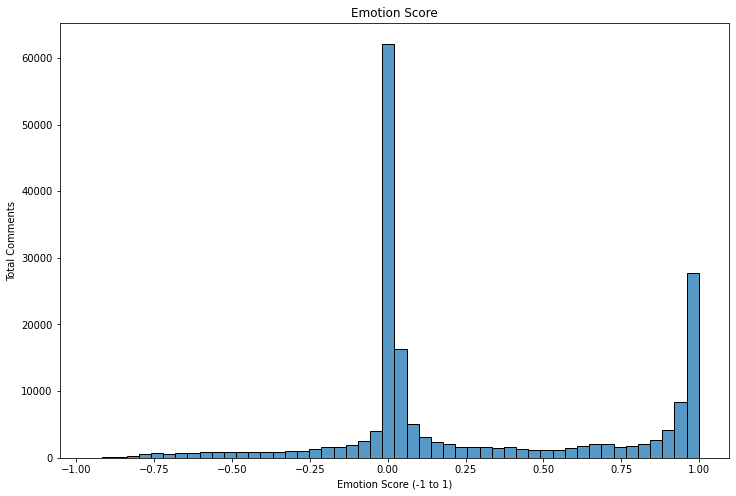

In [22]:
plt.figure(figsize=(12,8))
sns.histplot(df_comments_score["emotion_score"], bins=50, kde=False)
plt.xlabel("Emotion Score (-1 to 1)")
plt.ylabel("Total Comments")
plt.title("Emotion Score")
plt.show();

In [23]:
def sentiment_label(score):
    if score < -0.2:
        label = 'negative'
    elif score > 0.2:
        label = 'positive'
    else:
        label = 'neutral'
    return label
        
df_comments_score["sentiment_label"] = df_comments_score["emotion_score"].apply(sentiment_label)

In [24]:
label_group = df_comments_score.groupby("sentiment_label")["sentiment_label"].count()

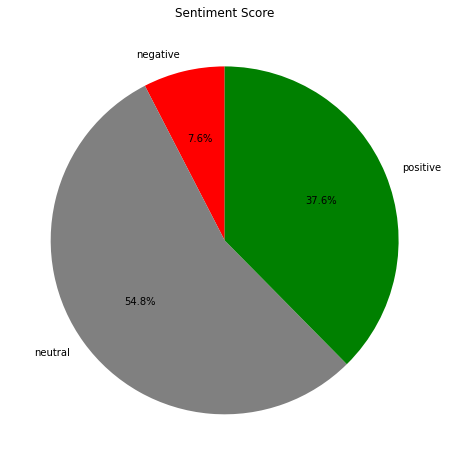

In [25]:
plt.figure(figsize=(12,8))
plt.pie(label_group, labels=label_group.index, autopct='%1.1f%%', startangle=90, colors=['red', 'gray', 'green'])
plt.title("Sentiment Score")
plt.show();

# 3. Temporal Sentiment Trend Analysis (WIP)

In [26]:
# Load video data
df_videos = pd.read_csv('../data/clean_data/df_video_data.csv')
df_videos["publishedAt"] = pd.to_datetime(df_videos["publishedAt"])
df_videos_date = df_videos[["videoId", "publishedAt", "likeCount"]]
df_videos_date.head()

,videoId,publishedAt,likeCount
0,qtlUwwtvuEg,2023-05-01 13:00:18+00:00,8091
1,QaoDXYYtgK0,2017-07-31 23:32:53+00:00,35258
2,PqDwddEHswU,2021-04-13 13:15:02+00:00,2575
3,B-Y7rnOa43w,2023-04-07 13:39:48+00:00,270
4,vyit-1zKsZ4,2022-12-13 17:00:35+00:00,2030


In [27]:
emotion_score = df_with_sentiment.select("comment_id", "emotion_score").toPandas()

24/11/01 15:42:58 WARN TaskSetManager: Stage 6 contains a task of very large size (9365 KiB). The maximum recommended task size is 1000 KiB.


In [28]:
df_result = pd.concat([df_result, emotion_score["emotion_score"]], axis=1)
df_result = df_result.merge(df_videos_date, left_on='video_id', right_on='videoId', how='inner')
df_result.drop(columns='videoId', inplace=True)
df_result.rename(columns={'publishedAt': 'video_publishedat', 'likeCount': 'video_likes'}, inplace=True)

In [29]:
df_result["days_from_publication"] = df_result["published_at"].dt.date - df_result["video_publishedat"].dt.date

In [30]:
video_sentiment_trend = df_result.groupby(['video_id', 'days_from_publication'])['like_count'].sum().unstack()

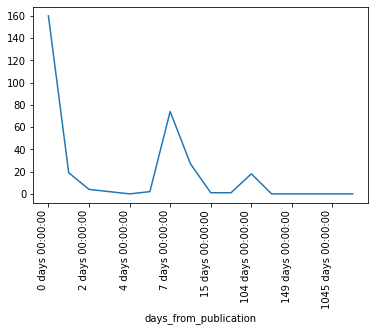

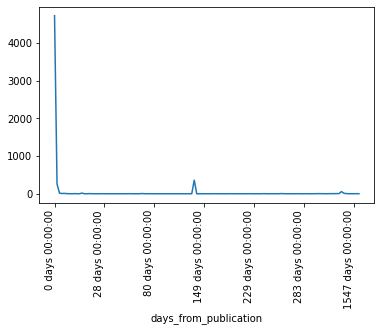

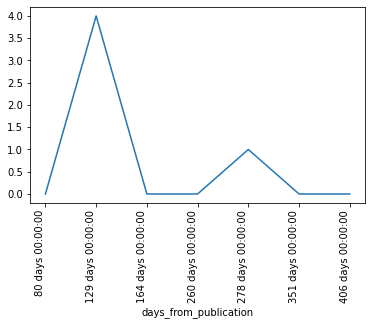

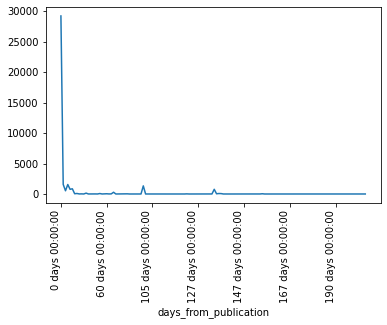

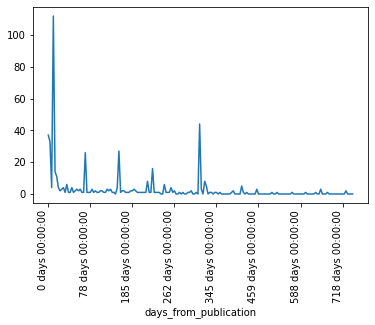

In [31]:
# Plot the results

for n in np.random.choice(range(len(video_sentiment_trend)), size=5):
    video_sentiment_trend.iloc[n].dropna().plot()

    plt.xticks(rotation=90)
    plt.show();

# 4. Temporal Emotion Trend

In [32]:
# Add the emotion_score column to the dataframe
df_result['emotion_score'] = df_comments_score['emotion_score']

Let's group the comments into bins from publication day:
* Same day (0 days).
* 2 days after (1-2 days).
* First 7 days (3-7 days).
* First month (8-30 days).
* First 3 months (31-90 days).
* First year (91-365 days).
* More than a year (>365 days).

In [33]:
def bins_days_from_publication(days):
    days = days.days
    if days == 0:
        return 0
    elif days <= 2:
        return 2
    elif days <= 7:
        return 7
    elif days <= 30:
        return 30
    elif days <= 90:
        return 90
    elif days <= 365:
        return 365
    elif days > 365:
        return 366
    else:
        return -1

df_result['time_bin_from_publication'] = df_result['days_from_publication'].apply(bins_days_from_publication)

In [34]:
df_result[['days_from_publication', 'time_bin_from_publication']].head()

,days_from_publication,time_bin_from_publication
0,"474 days, 0:00:00",366
1,0:00:00,0
2,"80 days, 0:00:00",90
3,"55 days, 0:00:00",90
4,"30 days, 0:00:00",30


In [35]:
# Agrupar por video_id y días desde la publicación, luego calcular el promedio de emociones
df_avg_emotions_by_day = df_result.groupby(['video_id', 'time_bin_from_publication'])['emotion_score'].mean().reset_index()

# Renombrar columnas para mayor claridad
df_avg_emotions_by_day.columns = ['video_id', 'time_bin_from_publication', 'avg_emotion_score']

# Visualizar el resultado
df_avg_emotions_by_day.head()

,video_id,time_bin_from_publication,avg_emotion_score
0,-3Yexx70g24,0,0.698126
1,-3Yexx70g24,2,0.161813
2,-3Yexx70g24,7,0.073191
3,-3Yexx70g24,30,0.184070
4,-4N27QlgJNQ,0,0.071003


Emotions Trend per Video

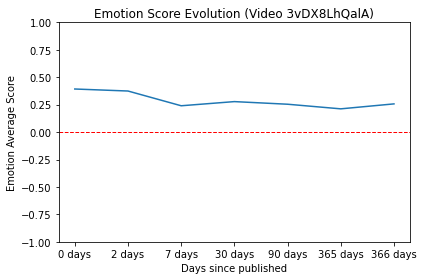

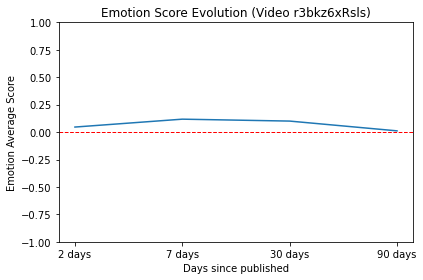

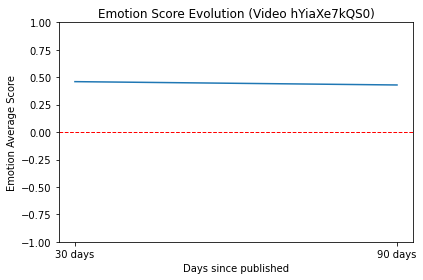

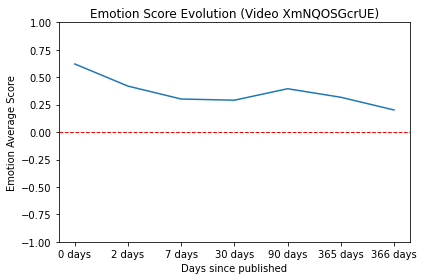

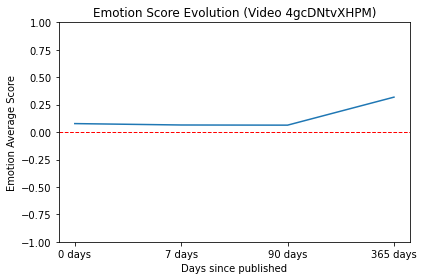

In [36]:
# Filtrar para un video específico, por ejemplo, video_id = '12345'
video_list = df_avg_emotions_by_day['video_id'].unique()
video_id_list = np.random.choice(video_list, size=5)

# Gráfico de líneas para ver la evolución emocional
for video_id in video_id_list:
    video_data = df_avg_emotions_by_day[df_avg_emotions_by_day['video_id'] == video_id]
    
    # Extract days_from_publication (string) and avg_emotion_score (numeric)
    days_labels = np.array(video_data['time_bin_from_publication'])
    avg_emotion_score = np.array(video_data['avg_emotion_score'])

    # Create a numerical index to use for plotting (since days_from_publication are strings)
    x_positions = np.arange(len(days_labels))

    # Create a scatter plot of the evolution of emotions over time
    plt.plot(x_positions, avg_emotion_score)
    
    days_labels_with_suffix = [f"{label} days" for label in days_labels]


    # Set the x-ticks to show the string labels from days_from_publication
    plt.xticks(x_positions, days_labels_with_suffix, rotation=0)  # Rotate if necessary for readability

    # Add labels, title, and red dotted line at y=0
    plt.title(f'Emotion Score Evolution (Video {video_id})')
    plt.xlabel('Days since published')
    plt.ylabel('Emotion Average Score')
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
    plt.ylim(-1, 1)

    # Show plot
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.show()

All Comments Emotion Trend

In [37]:
video_data = df_avg_emotions_by_day.groupby('time_bin_from_publication')['avg_emotion_score'].mean().reset_index()

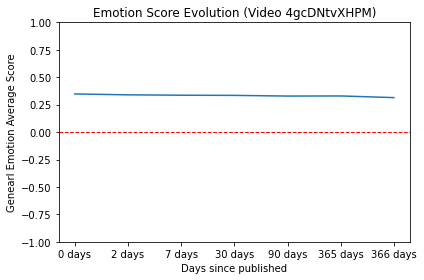

In [38]:
# Extract days_from_publication (string) and avg_emotion_score (numeric)
days_labels = np.array(video_data['time_bin_from_publication'])
avg_emotion_score = np.array(video_data['avg_emotion_score'])

# Create a numerical index to use for plotting (since days_from_publication are strings)
x_positions = np.arange(len(days_labels))

# Create a scatter plot of the evolution of emotions over time
plt.plot(x_positions, avg_emotion_score)

days_labels_with_suffix = [f"{label} days" for label in days_labels]


# Set the x-ticks to show the string labels from days_from_publication
plt.xticks(x_positions, days_labels_with_suffix, rotation=0)  # Rotate if necessary for readability

# Add labels, title, and red dotted line at y=0
plt.title(f'Emotion Score Evolution (Video {video_id})')
plt.xlabel('Days since published')
plt.ylabel('Genearl Emotion Average Score')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.ylim(-1, 1)

# Show plot
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

# 5. Emotions that generate more comment likes (correlation)

In [39]:
emotion_columns = selected_columns

df_emotion_likes = df_result[emotion_columns + ['like_count', 'video_id']]

df_emotion_likes = df_emotion_likes.groupby('video_id').sum()

correlation_matrix = df_emotion_likes[emotion_columns + ['like_count']].corr()

In [40]:
emotion_like_correlation = correlation_matrix['like_count'].drop('like_count')

In [41]:
sorted_correlation = emotion_like_correlation.sort_values(ascending=False)

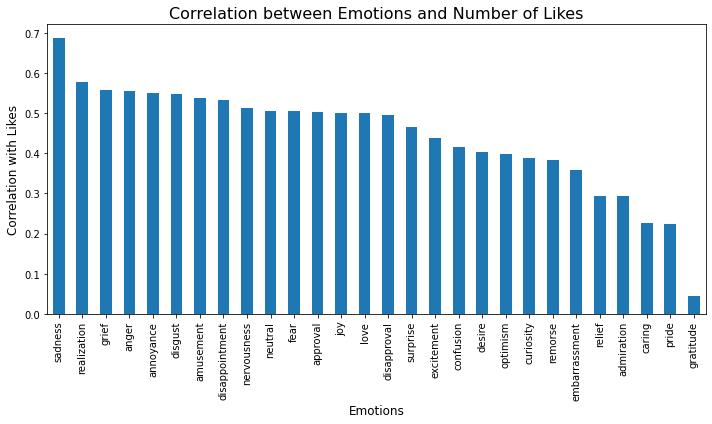

In [42]:
import matplotlib.pyplot as plt

# Plot the correlation between emotions and likes
plt.figure(figsize=(10, 6))
sorted_correlation.plot(kind='bar')

# Add labels and title
plt.title('Correlation between Emotions and Number of Likes', fontsize=16)
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Correlation with Likes', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# 6.Emotions that generate more video likes

In [43]:
df_emotion_sum = df_emotion_likes.merge(df_videos[['likeCount', 'videoId']], left_on='video_id', right_on='videoId', how='inner')

In [44]:
correlation_matrix = df_emotion_sum[emotion_columns + ['likeCount']].corr()

In [45]:
correlation_like_videos = correlation_matrix['likeCount'].drop('likeCount').sort_values(ascending=False)

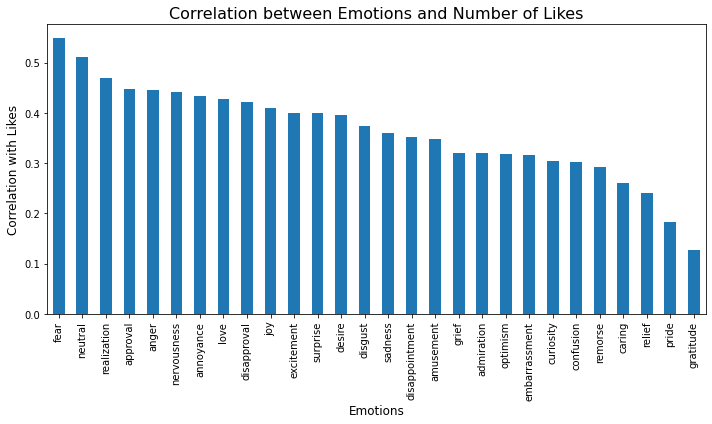

In [46]:
import matplotlib.pyplot as plt

# Plot the correlation between emotions and likes
plt.figure(figsize=(10, 6))
correlation_like_videos.plot(kind='bar')

# Add labels and title
plt.title('Correlation between Emotions and Number of Likes', fontsize=16)
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Correlation with Likes', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

We can conclude that there is no correlation between the emotions and the like count

# 7. Correlation between Words and Emotion_Score

In [47]:
# Create bins and emotion_score categories
bins = [-1, -0.6, -0.2, 0.2, 0.6, 1]
labels = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']

# Asign tags to emotion categories
df_result['emotion_category'] = pd.cut(df_result['emotion_score'], bins=bins, labels=labels, include_lowest=True)
df_result[['emotion_score', 'emotion_category']].head()

,emotion_score,emotion_category
0,0.966621,Very Positive
1,0.983798,Very Positive
2,0.988546,Very Positive
3,0.995094,Very Positive
4,0.986203,Very Positive


Create WordCloud per Emotion Category

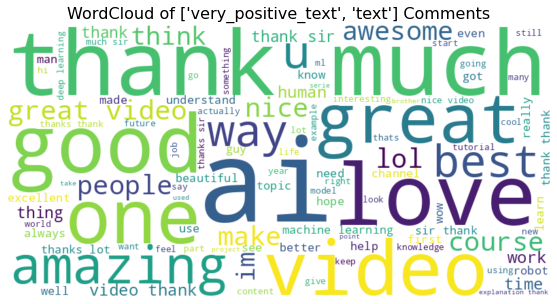

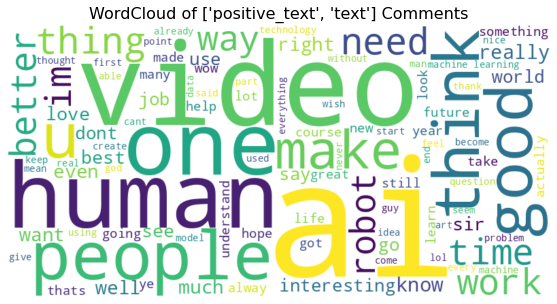

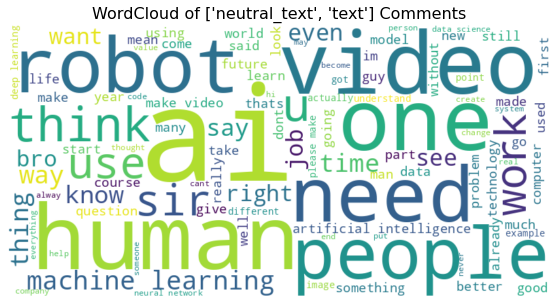

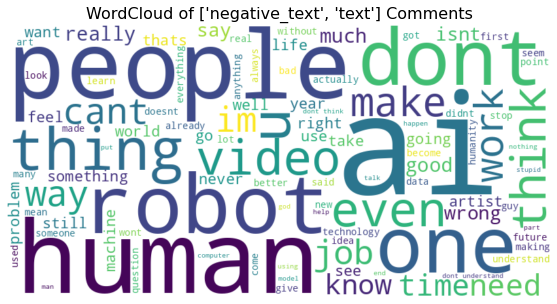

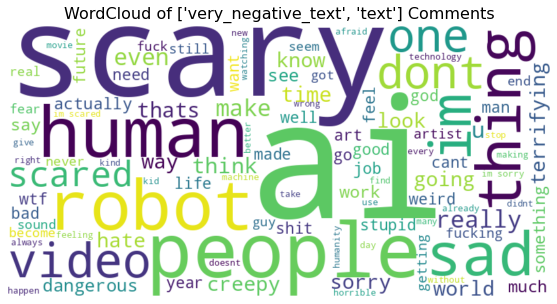

In [48]:
from wordcloud import WordCloud
from collections import Counter

# Compile the comments into a string per emotion category
very_positive_text = ' '.join(df_result[df_result['emotion_category'] == 'Very Positive']['clean_text'])
positive_text = ' '.join(df_result[df_result['emotion_category'] == 'Positive']['clean_text'])
neutral_text = ' '.join(df_result[df_result['emotion_category'] == 'Neutral']['clean_text'])
negative_text = ' '.join(df_result[df_result['emotion_category'] == 'Negative']['clean_text'])
very_negative_text = ' '.join(df_result[df_result['emotion_category'] == 'Very Negative']['clean_text'])

# Create WordCloud per emotion Category
text_list = [very_positive_text, positive_text, neutral_text, negative_text, very_negative_text]

# Visualize the WordCloud
for text in text_list:
    
    # Create WordCloud per emotion Category
    wordcloud_text = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(text)
    variable_name = [name for name in globals() if globals()[name] is text]
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_text, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud of {variable_name} Comments', fontsize=16)
    plt.show()


Correlation Emotions_Score / Words

1. Vectorize the comments

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

emotion_category = 'Neutral'

# Select the most frequent words
max_features = 1000

# Create a matrix of words
vectorizer = CountVectorizer(max_features=max_features, stop_words='english')
X = vectorizer.fit_transform(df_result[df_result['emotion_category'] == emotion_category]['clean_text'])

# Get the list of words
words = vectorizer.get_feature_names_out()

# Convert the X matriz into a DataFrame
word_frequencies = pd.DataFrame(X.toarray(), columns=words)
word_frequencies.head()

,ability,able,access,according,account,accuracy,act,action,activation,actual,...,written,wrong,ya,ye,yeah,year,yes,youre,youtube,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
# Define the custom colors from your palette
colors = ['#D9043D', '#04C4D9', '#05F2F2', '#F20505']
cmap = ListedColormap(colors, name="custom_palette")

2. Calculate correlation between words and emotion_score

In [ ]:
correlations = {}

for word in words:
    word_column = word_frequencies[word]
    correlation = np.corrcoef(word_column, df_result[df_result['emotion_category'] == emotion_category]['emotion_score'])[0, 1]
    correlations[word] = correlation

correlation_df = pd.DataFrame(list(correlations.items()), columns=['word', 'correlation'])

# Set 'word' as the index to display on the x-axis
correlation_df.set_index('word', inplace=True)

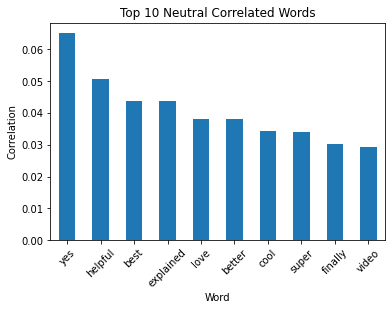

In [80]:
# Plot the top 10 correlations with words as x-axis labels
correlation_df.sort_values(by='correlation', ascending=False).head(10).plot(kind='bar', y='correlation', legend=False)

# Labeling
plt.ylabel('Correlation')
plt.xlabel('Word')
plt.title(f'Top 10 {emotion_category} Correlated Words')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()